In [5]:
# import tensorflow as tf

# cifar = tf.keras.datasets.cifar100
# (x_train, y_train), (x_test, y_test) = cifar.load_data()
# model = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights=None,
#     input_shape=(32, 32, 3),
#     classes=100,)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
# model.fit(x_train, y_train, epochs=5, batch_size=64)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np


In [7]:
def load_data(data_frame: pd.DataFrame):
    """
    Loads images and their corresponding labels.
    """ 
    images = []
    labels = [] 
    for index, row in data_frame.iterrows():
        for img_type in ['p', 'nut', 'ux', 'uy']:
            image_name = row[f'{img_type}_path']
            clipped_img_path = os.path.join('./raw_data_images', 'images', image_name)
            label = "_".join(image_name.split('_')[1:]).split('.')[0]  # Extract label from the filename
            if clipped_img_path and os.path.isfile(clipped_img_path):
                img = cv2.imread(clipped_img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224)).astype('float32') 
                    images.append(img)
                    # labels.append(row[f'{img_type}_label']) 
                    labels.append(label)
                else:
                    print(f"Warning: Unable to read image at {clipped_img_path}. Skipping this image.")

            # if 0_clipped_p.png and remeshed will be 0_remeshed_p.png replace with 0_clipped_p.png
            remeshed_img_path = clipped_img_path.replace('_clipped_', '_remeshed_')
            if remeshed_img_path and os.path.isfile(remeshed_img_path):
                remeshed_img = cv2.imread(remeshed_img_path)
                if remeshed_img is not None:
                    remeshed_img = cv2.resize(remeshed_img, (224, 224)).astype('float32')
                    images.append(remeshed_img)
                    # remeshed_labels.append(row[f'{img_type}_label']) 
                    remeshed_label = label.replace('clipped_', 'remeshed_')
                    labels.append(remeshed_label)
                else:
                    print(f"Warning: Unable to read remeshed image at {remeshed_img_path}. Skipping this image.")
            else:
                print(f"Warning: Image path {clipped_img_path} does not exist or is not a file. Skipping this image.")

    return np.array(images), np.array(labels)

#read the csv file meshdatasummery.csv as df
datadf = pd.read_csv('./raw_data_images/mesh_data_summary.csv')

images, labels = load_data(datadf)

In [8]:
labels = np.array(labels)
np.unique(labels)

array(['clipped_Ux', 'clipped_Uy', 'clipped_nut', 'clipped_p',
       'remeshed_Ux', 'remeshed_Uy', 'remeshed_nut', 'remeshed_p'],
      dtype='<U12')

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 

images = preprocess_input(images)  # Preprocess images for VGG16

# Encode string labels to integers
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)
# One-hot encode the integer labels
y = to_categorical(integer_encoded_labels)
num_classes = y.shape[1]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.1, random_state=42)

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
# GMSD_loss = pyiqa.create_metric('gmsd', as_loss=True, device='cpu')
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture history
history_10 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=8, verbose=1) 


2025-07-15 11:44:01.257041: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-15 11:44:01.257231: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-15 11:44:01.257242: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-15 11:44:01.257275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-15 11:44:01.257290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-07-15 11:44:08.941691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


900/900 [==============================] - ETA: 0s - loss: 2.6638 - accuracy: 0.5813

2025-07-15 11:45:58.330636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


900/900 [==============================] - 121s 134ms/step - loss: 2.6638 - accuracy: 0.5813 - val_loss: 1.0044 - val_accuracy: 0.6538
Epoch 2/10
900/900 [==============================] - 117s 130ms/step - loss: 0.8649 - accuracy: 0.6819 - val_loss: 0.9354 - val_accuracy: 0.6375
Epoch 3/10
900/900 [==============================] - 116s 128ms/step - loss: 0.8019 - accuracy: 0.7022 - val_loss: 0.8803 - val_accuracy: 0.6237
Epoch 4/10
900/900 [==============================] - 115s 128ms/step - loss: 0.6952 - accuracy: 0.7150 - val_loss: 0.9957 - val_accuracy: 0.6737
Epoch 5/10
900/900 [==============================] - 118s 131ms/step - loss: 0.6335 - accuracy: 0.7239 - val_loss: 0.7113 - val_accuracy: 0.6975
Epoch 6/10
900/900 [==============================] - 116s 129ms/step - loss: 0.5971 - accuracy: 0.7387 - val_loss: 0.6143 - val_accuracy: 0.7275
Epoch 7/10
900/900 [==============================] - 116s 129ms/step - loss: 0.5546 - accuracy: 0.7539 - val_loss: 0.9355 - val_accura

In [10]:
# continue with 50 epochs and save the model
history_50 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=8, verbose=1)

Epoch 1/40
900/900 [==============================] - 129s 143ms/step - loss: 0.4922 - accuracy: 0.7782 - val_loss: 0.6513 - val_accuracy: 0.7287
Epoch 2/40
900/900 [==============================] - 139s 155ms/step - loss: 0.4919 - accuracy: 0.7807 - val_loss: 0.6177 - val_accuracy: 0.7038
Epoch 3/40
900/900 [==============================] - 139s 154ms/step - loss: 0.5082 - accuracy: 0.7779 - val_loss: 0.6347 - val_accuracy: 0.7125
Epoch 4/40
900/900 [==============================] - 136s 151ms/step - loss: 0.4731 - accuracy: 0.7850 - val_loss: 0.5861 - val_accuracy: 0.7462
Epoch 5/40
900/900 [==============================] - 146s 162ms/step - loss: 0.4680 - accuracy: 0.7907 - val_loss: 0.5432 - val_accuracy: 0.7688
Epoch 6/40
900/900 [==============================] - 142s 158ms/step - loss: 0.4840 - accuracy: 0.7922 - val_loss: 0.6488 - val_accuracy: 0.7362
Epoch 7/40
900/900 [==============================] - 141s 157ms/step - loss: 0.4592 - accuracy: 0.7974 - val_loss: 0.8541 -

In [14]:
history_100 = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, verbose=1)

Epoch 1/50
900/900 [==============================] - 130s 143ms/step - loss: 0.3792 - accuracy: 0.8460 - val_loss: 0.8048 - val_accuracy: 0.7538
Epoch 2/50
900/900 [==============================] - 127s 142ms/step - loss: 0.3376 - accuracy: 0.8471 - val_loss: 0.6028 - val_accuracy: 0.7613
Epoch 3/50
900/900 [==============================] - 127s 142ms/step - loss: 0.3545 - accuracy: 0.8497 - val_loss: 0.7566 - val_accuracy: 0.7575
Epoch 4/50
900/900 [==============================] - 128s 142ms/step - loss: 0.3473 - accuracy: 0.8536 - val_loss: 0.6883 - val_accuracy: 0.7625
Epoch 5/50
900/900 [==============================] - 128s 142ms/step - loss: 0.3370 - accuracy: 0.8546 - val_loss: 0.6995 - val_accuracy: 0.7800
Epoch 6/50
900/900 [==============================] - 127s 141ms/step - loss: 0.3341 - accuracy: 0.8515 - val_loss: 0.6144 - val_accuracy: 0.8000
Epoch 7/50
900/900 [==============================] - 127s 141ms/step - loss: 0.3636 - accuracy: 0.8508 - val_loss: 0.6380 -

KeyboardInterrupt: 

In [11]:

# Save the trained model
model.save('vgg16_finetuned_comparitive.h5')

print("Model training complete and saved as vgg16_finetuned_remeshed.h5")

/Users/saikirannunemunthala/Files/Lectures/Thesis/AirfranceDatasetAnalysis/.conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model training complete and saved as vgg16_finetuned_remeshed.h5


In [17]:
# combile the history of all three training runs
history_combined = {
    'accuracy': history_10.history['accuracy'] + history_50.history['accuracy'],
    'val_accuracy': history_10.history['val_accuracy'] + history_50.history['val_accuracy'],
    'loss': history_10.history['loss'] + history_50.history['loss'],
    'val_loss': history_10.history['val_loss'] + history_50.history['val_loss']
}

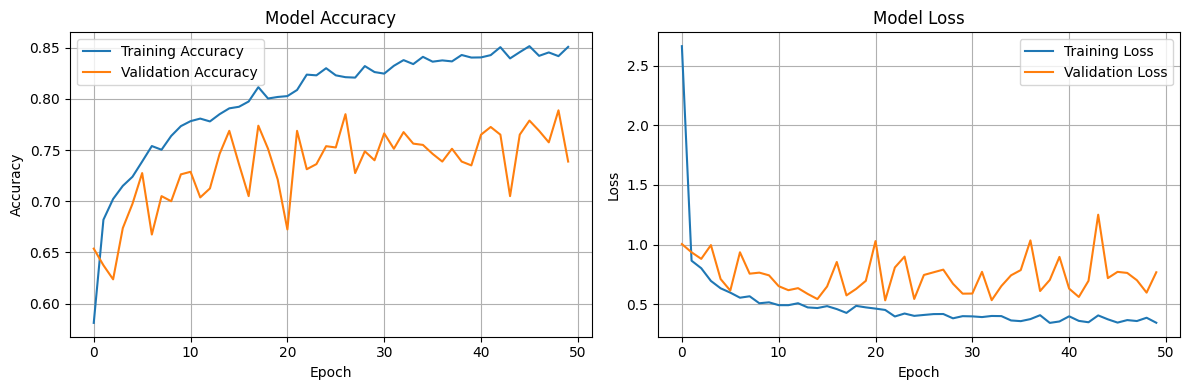

Final Training Accuracy: 0.8507
Final Validation Accuracy: 0.7387
Final Training Loss: 0.3445
Final Validation Loss: 0.7680


In [18]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_combined['accuracy'], label='Training Accuracy')
plt.plot(history_combined['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_combined['loss'], label='Training Loss')
plt.plot(history_combined['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"Final Training Accuracy: {history_combined['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_combined['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_combined['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_combined['val_loss'][-1]:.4f}")